<a href="https://colab.research.google.com/github/mengwangk/trading-playground/blob/master/notebook/LSTM_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM
import io

In [7]:
from google.colab import files
uploaded = files.upload()
# print(uploaded)

Saving GENTING_data_set.csv to GENTING_data_set.csv
Saving GENTING_train_set.csv to GENTING_train_set.csv
Saving GENTING_test_set.csv to GENTING_test_set.csv


In [57]:
UOM = {'K': 1000, 'M': 1000000}

def convert_to_numeric(val):
    return float(val[:-1]) * UOM[val[-1]]

def clean_dataset(df):
    df.rename(columns={'Price':'Close', 'Vol.':'Volume'}, inplace=True)
    df.drop(columns=['Change %'], axis=1, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df['Volume'] = df['Volume'].apply(convert_to_numeric)
    df.sort_values(by=['Date'], ascending=True, inplace=True)
    #df.set_index('Date', inplace=True)

# dataset = pd.read_csv('data/GENTING_data_set.csv', parse_dates=True)
#print(uploaded)
dataset = pd.read_csv(io.StringIO(uploaded['GENTING_train_set.csv'].decode('utf-8')), parse_dates=True)
clean_dataset(dataset)
df = dataset.iloc[:, 0:2]
print(df.dtypes)
df.set_index(['Date'], drop=True,inplace=True)
df.head(10)
#print(type(dataset.iloc[:, 1:2].values))

Date     datetime64[ns]
Close           float64
dtype: object
<class 'numpy.ndarray'>


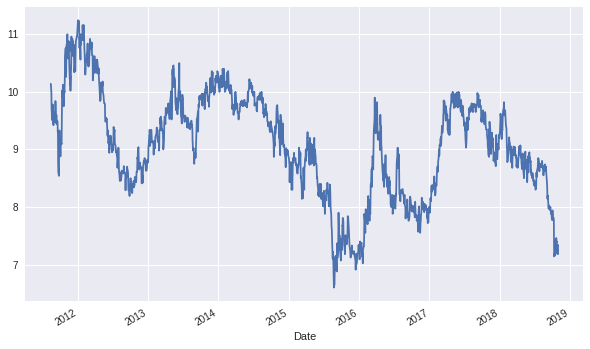

In [52]:
plt.figure(figsize=(10, 6))
df['Close'].plot();

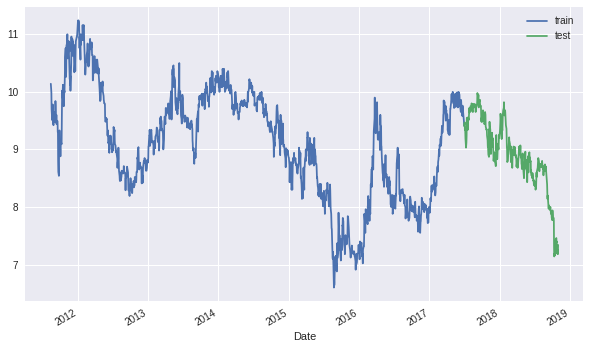

In [53]:
split_date = pd.Timestamp('2017-06-30')
df =  df['Close']
train = df.loc[:split_date]
test = df.loc[split_date:]
plt.figure(figsize=(10, 6))
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test']);

In [ ]:

scaler = MinMaxScaler(feature_range=(-1, 1))
train_sc = scaler.fit_transform(train.values.reshape(-1,1))
test_sc = scaler.transform(test.values.reshape(-1,1))
#print(train.values.reshape(-1,1))

In [ ]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [76]:
print(len(train_sc))
print(len(X_train))
print(len(y_train))

1442
1441
1441


In [78]:
print(train_sc)
print(X_train)

[[0.52586207]
 [0.50862069]
 [0.48275862]
 ...
 [0.25      ]
 [0.24568966]
 [0.2112069 ]]
[[0.52586207]
 [0.50862069]
 [0.48275862]
 ...
 [0.34482759]
 [0.25      ]
 [0.24568966]]


# NN

In [79]:
nn_model = Sequential()
nn_model.add(Dense(12, input_dim=1, activation='relu'))
nn_model.add(Dense(1))
nn_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1441/1441 [==============================] - 2s 1ms/step - loss: 0.0111
Epoch 2/100
1441/1441 [==============================] - 1s 837us/step - loss: 0.0041
Epoch 3/100
1441/1441 [==============================] - 1s 838us/step - loss: 0.0040
Epoch 4/100
1441/1441 [==============================] - 1s 835us/step - loss: 0.0039
Epoch 5/100
1441/1441 [==============================] - 1s 820us/step - loss: 0.0039
Epoch 6/100
1441/1441 [==============================] - 1s 842us/step - loss: 0.0038
Epoch 7/100
1441/1441 [==============================] - 1s 817us/step - loss: 0.0038
Epoch 8/100
1441/1441 [==============================] - 1s 813us/step - loss: 0.0038
Epoch 9/100
1441/1441 [==============================] - 1s 799us/step - loss: 0.0038
Epoch 10/100
1441/1441 [==============================] - 1s 825us/step - loss: 0.0038
Epoch 11/100
1441/144

In [80]:
y_pred_test_nn = nn_model.predict(X_test)
y_train_pred_nn = nn_model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_nn)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_nn)))


The R2 score on the Train set is:	0.944
The R2 score on the Test set is:	0.905


# LSTM

In [ ]:
train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)

for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)

X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)

X_train = X_train.as_matrix()
y_train = y_train.as_matrix()

X_test = X_test.as_matrix()
y_test = y_test.as_matrix()


In [82]:
X_train_lmse = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lmse = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print('Train shape: ', X_train_lmse.shape)
print('Test shape: ', X_test_lmse.shape)


Train shape:  (1441, 1, 1)
Test shape:  (326, 1, 1)


In [83]:
lstm_model = Sequential()
lstm_model.add(LSTM(7, input_shape=(1, X_train_lmse.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history_lstm_model = lstm_model.fit(X_train_lmse, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
1441/1441 [==============================] - 3s 2ms/step - loss: 0.0502
Epoch 2/100
1441/1441 [==============================] - 3s 2ms/step - loss: 0.0049
Epoch 3/100
1441/1441 [==============================] - 3s 2ms/step - loss: 0.0037
Epoch 4/100
1441/1441 [==============================] - 3s 2ms/step - loss: 0.0036
Epoch 5/100
1441/1441 [==============================] - 3s 2ms/step - loss: 0.0036
Epoch 6/100
1441/1441 [==============================] - 3s 2ms/step - loss: 0.0036
Epoch 7/100
1441/1441 [==============================] - 3s 2ms/step - loss: 0.0036
Epoch 8/100
1441/1441 [==============================] - 3s 2ms/step - loss: 0.0036
Epoch 9/100
1441/1441 [==============================] - 3s 2ms/step - loss: 0.0036
Epoch 10/100
1441/1441 [==============================] - 3s 2ms/step - loss: 0.0035
Epoch 11/100
1441/1441 [==============================] - 3s 2ms/step - loss: 0.0035
Epoch 12/100
1441/1441 [==============================] - 3s 2ms/step - lo

In [84]:
y_pred_test_lstm = lstm_model.predict(X_test_lmse)
y_train_pred_lstm = lstm_model.predict(X_train_lmse)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))


The R2 score on the Train set is:	0.963
The R2 score on the Test set is:	0.940


In [85]:
nn_test_mse = nn_model.evaluate(X_test, y_test, batch_size=1)
lstm_test_mse = lstm_model.evaluate(X_test_lmse, y_test, batch_size=1)
print('NN: %f'%nn_test_mse)
print('LSTM: %f'%lstm_test_mse)

326/326 [==============================] - 0s 969us/step
NN: 0.006793
LSTM: 0.004321


In [ ]:
nn_y_pred_test = nn_model.predict(X_test)
lstm_y_pred_test = lstm_model.predict(X_test_lmse)


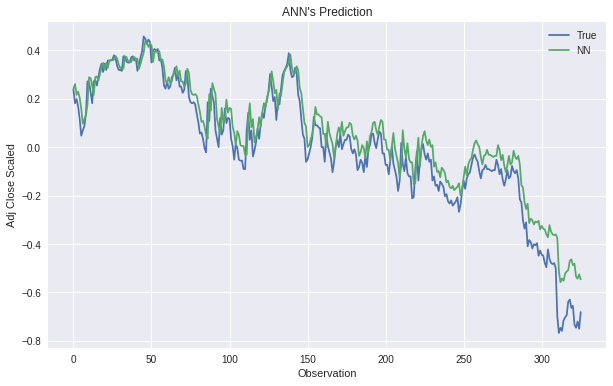

In [87]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_nn, label='NN')
plt.title("ANN's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close Scaled')
plt.legend()
plt.show();

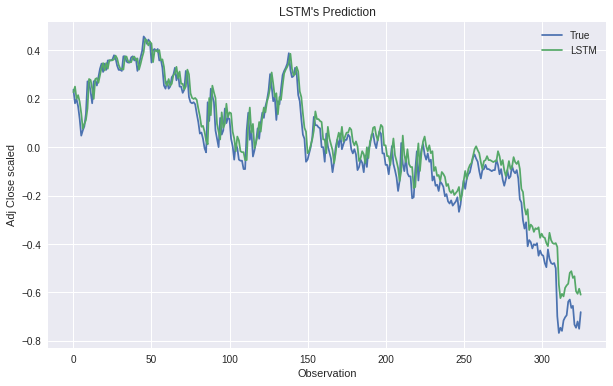

In [88]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close scaled')
plt.legend()
plt.show();